In [1]:
%matplotlib nbagg
#from photodiag import PalmSetup
import photodiag
import json
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import h5py
import os, glob

from alvra_tools.load_data import *
from alvra_tools.channels import *
from scipy.special import erf
from scipy.optimize import curve_fit
from alvra_tools import load_data
from IPython.display import clear_output
from ipyfilechooser import FileChooser

# First part: load a THz scan to calibrate the eV to fs slope

### First look for the correct PALM calibration file

In [2]:
#DIRcalib = '/sf/photo/src/PALM/calib/'
#DIRcalib = '/sf/photo/src/PALM/calib/Alvra'
#DIRcalib = '/sf/alvra/data/p18442/res/PhotoDiag/scan_info/'
#DIRcalib = '/sf/alvra/data/p18182/res/PhotoDiag/scan_info/'
DIRcalib = '/sf/alvra/data/p17589/res/PhotoDiag/scan_info/'


!ls -lah -rt $DIRcalib | grep palm_etof

-rw-r--r--. 1            39147 p17589 254K Oct 24  2018 2018-10-24_12:12:13.palm_etof
-rw-r--r--. 1            39147 p17589 349K Feb 28  2019 2019-02-28_12:18:56.palm_etof
-rw-r--r--. 1            39147 p17589 254K Mar 25  2019 2019-03-25_11:53:57.palm_etof
-rw-r--r--. 1            39147 p17589 254K Apr 28  2019 2019-04-28_14:37:31.palm_etof
-rw-r--r--. 1            39147 p17589 254K May  1  2019 2019-05-01_22:34:29.palm_etof
-rw-r--r--. 1            39147 p17589 254K Jul  5  2019 2019-07-05_10:44:32.palm_etof
-rw-r--r--. 1            39147 p17589 254K Mar 10 16:26 2020-03-10_16:26:51.palm_etof
-rw-r--r--. 1            39147 p17589 254K Jul  3 10:44 2020-07-03_10:44:41.palm_etof


### Now load the calibration file and give the energy range

In [3]:
#CalibrationFn = DIRcalib + '2019-05-24_13:40:42.palm_etof'     # 12 keV settings
#CalibrationFn = DIRcalib + '2020-01-25_16:28:32.palm_etof'     # 5 keV settings -- p18182
CalibrationFn = DIRcalib + '2020-07-03_10:44:41.palm_etof'     # 7.5 keV settings


energyFrom =  2200
energyTo =    2500
energySteps = 2000

###########################################################################################

palm = photodiag.PalmSetup({'0': 'SAROP11-PALMK118:CH1_BUFFER', '1': 'SAROP11-PALMK118:CH2_BUFFER'},
                 noise_range=[0, 250],
                 energy_range=np.linspace(energyFrom, energyTo, energySteps))

palm.load_etof_calib(CalibrationFn)    

# define the fitfunction
def fitThz(x, a, b, c, d, e, f):
    return a + b*np.exp(-(c-x)**2/np.abs(d)**2)*np.sin(e*x + f) 


### Now choose the directory of the json file for the THz scan

In [4]:
fc = FileChooser('/sf/alvra/data/p17589/res/scan_info/') #this is for slic
#fc = FileChooser('/sf/alvra/data/p17589/raw/scan_info/')  #this is for RC
fc.use_dir_icons = True
display(fc)

FileChooser(path='/sf/alvra/data/p17589/res/scan_info', filename='', show_hidden='False')

 ### Load the THz scan

In [5]:
#scan_name = 'scan0000_2020-07-03-thz-time-calib-slic_004'

#bsfile = "/sf/alvra/data/p18389/res/PhotoDiag/scan_data/2020-03-16-palm_calib_007_step0000.h5"

###########################################
fn_json = fc.selected
#fn_json = DIRjson + scan_name + '_scan_info.json'
channel_list = [channel_Events, 'SAROP11-PALMK118:CH2_BUFFER','SAROP11-PALMK118:CH1_BUFFER']

with open(fn_json) as f:
    dataFiles = json.load(f)
numFiles = len(dataFiles['scan_files'])
StagePOS = dataFiles['scan_values'][:]

eVIntP = []
eVIntUp = []
wf_str = []
wf_ref = []

for i in range(0,numFiles):
    fn = str(dataFiles['scan_files'][i][0])
    
    with SFDataFiles(fn) as data:
        subset = data[channel_list]
        subset.print_stats(show_complete=True)
        subset.drop_missing()

        TOF = -subset['SAROP11-PALMK118:CH2_BUFFER'].data
        uTOF = -subset['SAROP11-PALMK118:CH1_BUFFER'].data
        try:
            ### will use the following lines will work if there is TIFALL5 in the channel list
            EventCode = subset[channel_Events].data
        
            FEL = EventCode[:,48]
            Laser = EventCode[:,18]
            Darkshot = EventCode[:,21]
            index_ok = np.logical_and.reduce((FEL, Laser, np.logical_not(Darkshot)))
            print ('Shots selection done with event code')
        except:
            ### will use the following line if there is no TIFALL5, need to know the FEL/laser reprate however...
            mod = 2   # for 50 Hz
            index_ok = PulseIds%mod == 0          
            print ('Shots selection done with pulseID modulo = {}'.format(mod))
                
        tmpP = palm.etofs['1'].convert(input_data=TOF[index_ok], interp_energy=palm.energy_range)
        tmpUp = palm.etofs['0'].convert(input_data=uTOF[index_ok],interp_energy=palm.energy_range)
        
        eVIntP.append(tmpP)
        eVIntUp.append(tmpUp)
        wf_str.append(TOF[index_ok])
        wf_ref.append(uTOF[index_ok])
        clear_output(wait=True)
        print('Loaded file %s' %str(dataFiles['scan_files'][i][0]))


minlen = min(len(i) for i in wf_str)

eVIntP = np.array(eVIntP)
eVIntUp = np.array(eVIntUp)

def cut(arr, minlen):
    return np.array([i[:minlen] for i in arr])

wf_str = cut(wf_str, minlen)
wf_ref = cut(wf_ref, minlen)
eVIntP = cut(eVIntP, minlen)
eVIntUp = cut(eVIntUp, minlen)


StagePOS = np.array(StagePOS)
Stagefs = (StagePOS[:,0]*1e-3*2/3e8)*1e15

print('Datasize = {}'.format(wf_str.shape))

Loaded file /sf/alvra/data/p17589/raw/scan_data/scan0000_2020-07-03-thz-time-calib-slic_004/scan0000_2020-07-03-thz-time-calib-slic_004_step0030/run_000741.*.h5
Datasize = (31, 250, 2000)


 ### Plot the THz scan to see whether the energy range is fine

<IPython.core.display.Javascript object>


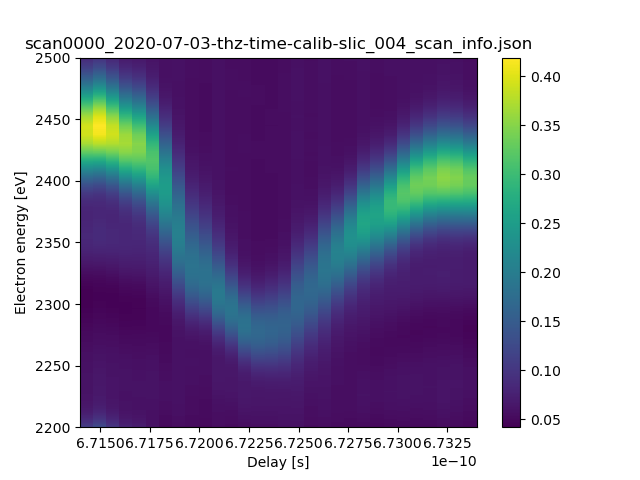

In [6]:
fig = plt.figure()
plt.pcolormesh(StagePOS[:,0], palm.energy_range, np.transpose(eVIntP.mean(axis=1)))
plt.xlabel('Delay [s]')
plt.ylabel('Electron energy [eV]')
plt.title(fc.selected_filename)
plt.colorbar()
plt.show()
#plt.savefig (savedir + scan_name + 'THz_raw.png')

 ### Now calculate t0 and calibration factor with the fit

t0 is at 6.718318364307661e-10 s
Max streak is 167.0335167583794 eV
t0 from phase is at 6.719710604281002e-10 s
Calibration factor is -3.1824981756907595 eV/fs
213477.6209041843


<IPython.core.display.Javascript object>


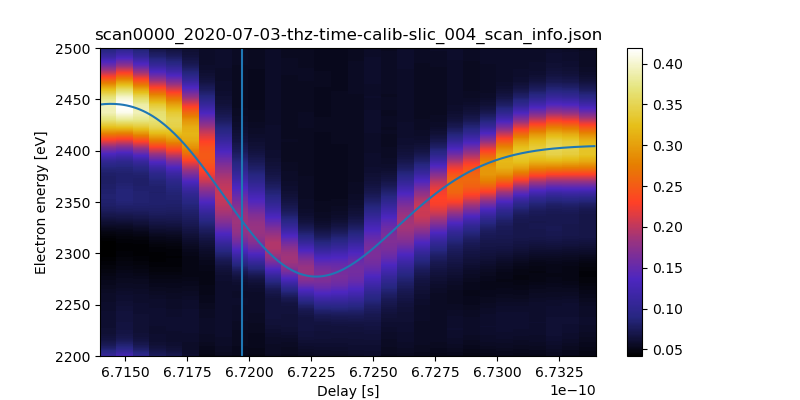

Scan scan0000_2020-07-03-thz-time-calib-slic_004_scan_info.json, t0 from phase = 6.719710604281002e-10 and peak-to-peak streak of 168.24 eV


In [7]:
### Load is done, now run this cell to calculate the calibration factor (eV2fs)
### For p18182 (5 keV) found -28.240766953955095 eV/fs
### For p18389 (12 keV) found -4.610191678065906 eV/fs

# determining t0 and peak-to-peak distance
streak=np.transpose(np.array([StagePOS[:,0], palm.energy_range[np.argmax(np.transpose(eVIntP.mean(axis=1)),axis =0)]]))
streakDerivative=np.transpose(np.array([[np.mean(t) for t in np.transpose([streak[:-1,0],streak[1:,0]])],np.diff(streak[:,1])/np.diff(streak[:,0])]))
#streakDerivative=np.transpose(np.array([streak[:-1,0],np.diff(streak[:,1])/np.diff(streak[:,0])]))
t0=[t[0] for t in streakDerivative if t[1]==min(streakDerivative[:,1])][0]

print("t0 is at {} s".format(t0))
print("Max streak is {} eV".format(max(np.array([t for t in streak if t[0]<t0])[:,1])-min(np.array([t for t in streak if t[0]>t0])[:,1])))

#Now fit with fit function
param_bounds = ([300,10,5.4e-10,1e-13,2e12,0],[600,500,5.5e-10,3e-12,4e12,np.inf])
parameters,extras = curve_fit(fitThz,StagePOS[:,0],palm.energy_range[np.argmax(np.transpose(eVIntP.mean(axis=1)),axis =0)], 
                              p0 = [np.min(palm.energy_range), 50, t0,2e-12,2.8e12,1])#,bounds=param_bounds)
# make the derivative 
dx = StagePOS[2,0]-StagePOS[1,0]
d_fitTHz_dx = np.gradient(fitThz(StagePOS[:,0],*parameters), dx)

max_y = np.max(np.gradient(fitThz(StagePOS[:,0],*parameters)))  # Find the maximum y value
max_x = np.argmin(np.gradient(fitThz(StagePOS[:,0],*parameters)))  # Find the maximum y value

# t0 from the phase fit 
t0_from_phase = parameters[2] + (parameters[4]*parameters[5])**-1 

calibrationLineSlope=np.interp(t0_from_phase,StagePOS[:,0],d_fitTHz_dx)
calibrationLineIntercept=np.interp(t0_from_phase,StagePOS[:,0],fitThz(StagePOS[:,0],*parameters))-calibrationLineSlope*t0_from_phase
ev2fsCalib = 1/(calibrationLineSlope*1e-15)
#print(max_x, max_y)
print ("t0 from phase is at {} s".format(t0_from_phase))
print ("Calibration factor is {} eV/fs".format(ev2fsCalib))
#print(parameters[2])
#print([calibrationLineSlope,calibrationLineIntercept,t0_from_phase])
print (calibrationLineIntercept)
# Trace from fit
xS=np.arange(np.min(StagePOS[:,0]),np.max(StagePOS[:,0]),(np.max(StagePOS[:,0])-np.min(StagePOS[:,0]))/300)
ySFitted=[fitThz(x, parameters[0],parameters[1],parameters[2],parameters[3],parameters[4],parameters[5]) for x in xS]

# Trace line 
#Trace_lin_fit = calibrationLineSlope * 


# Plot
fig = plt.figure(figsize=(8,4))
plt.pcolormesh(StagePOS[:,0], palm.energy_range, np.transpose(eVIntP.mean(axis=1)), cmap='CMRmap')
plt.colorbar()
plt.plot(xS,ySFitted)
plt.axvline(t0_from_phase)
plt.xlabel('Delay [s]')
plt.ylabel('Electron energy [eV]')

plt.title(fc.selected_filename)
plt.show()
PeakToPeak = np.max(ySFitted)-np.min(ySFitted)
print('Scan {}, t0 from phase = {} and peak-to-peak streak of {} eV'.format(fc.selected_filename, t0_from_phase, np.round(PeakToPeak,2)))
#plt.savefig (savedir + scan_name + 'THz_fit.png')

In [9]:
DIR = "/sf/alvra/data/p17589/raw/2020-07-02_YAG_timing_9/"

!ls -lah -rt $DIR | grep BSREAD

!hostname

listfile = os.listdir(DIR)
number_files = len(listfile)
print ("There are",number_files," BSREAD files in the folder", DIR)

-rw-r--r--.  1 root p17589 881M Jul  2 22:38 run_000284.BSREAD.h5
-rw-r--r--.  1 root p17589 881M Jul  2 22:41 run_000285.BSREAD.h5
-rw-r--r--.  1 root p17589 882M Jul  2 22:45 run_000286.BSREAD.h5
-rw-r--r--.  1 root p17589 880M Jul  2 22:48 run_000287.BSREAD.h5
-rw-r--r--.  1 root p17589 880M Jul  2 22:51 run_000288.BSREAD.h5
-rw-r--r--.  1 root p17589 880M Jul  2 22:55 run_000289.BSREAD.h5
-rw-r--r--.  1 root p17589 879M Jul  2 22:58 run_000290.BSREAD.h5
-rw-r--r--.  1 root p17589 879M Jul  2 23:01 run_000291.BSREAD.h5
-rw-r--r--.  1 root p17589 880M Jul  2 23:04 run_000292.BSREAD.h5
-rw-r--r--.  1 root p17589 882M Jul  2 23:08 run_000293.BSREAD.h5
-rw-r--r--.  1 root p17589 880M Jul  2 23:11 run_000294.BSREAD.h5
-rw-r--r--.  1 root p17589 881M Jul  2 23:14 run_000295.BSREAD.h5
-rw-r--r--.  1 root p17589 881M Jul  2 23:17 run_000296.BSREAD.h5
-rw-r--r--.  1 root p17589 880M Jul  2 23:21 run_000297.BSREAD.h5
-rw-r--r--.  1 root p17589 880M Jul  2 23:24 run_000298.BSREAD.h5
-rw-r--r--

ra-c-004.psi.ch
There are 714  BSREAD files in the folder /sf/alvra/data/p17589/raw/2020-07-02_YAG_timing_9/


In [10]:
fc = FileChooser(DIR)
display(fc)

FileChooser(path='/sf/alvra/data/p17589/raw/2020-07-02_YAG_timing_9', filename='', show_hidden='False')

In [11]:
# Analyse a single file, no dark / light selection of the shots!!

fff = fc.selected
#print (os.path.isfile(fileName))

with h5py.File(fff, 'r') as fileName:
    fileName = load_data._get_data(fileName)
    check = fileName["SAR-CVME-TIFALL5:EvtSet/is_data_present"][:]
    

#pulse_id, delays, pulse_lengths, debug_data = palm.process_hdf5_file(fileName, debug=True)

pulse_id, delays, _, (input_data, lags, cross_corr, _) = palm.process_hdf5_file(fff, debug=True)
#ev2fsCalib = -3.5391553376634146
delays_fs = delays * ev2fsCalib

Delay for shot 2 = 362.98628517133227 with calibration = -3.1824981756907595 eV/fs
0.09569416660717996
17139.323456704573


<IPython.core.display.Javascript object>


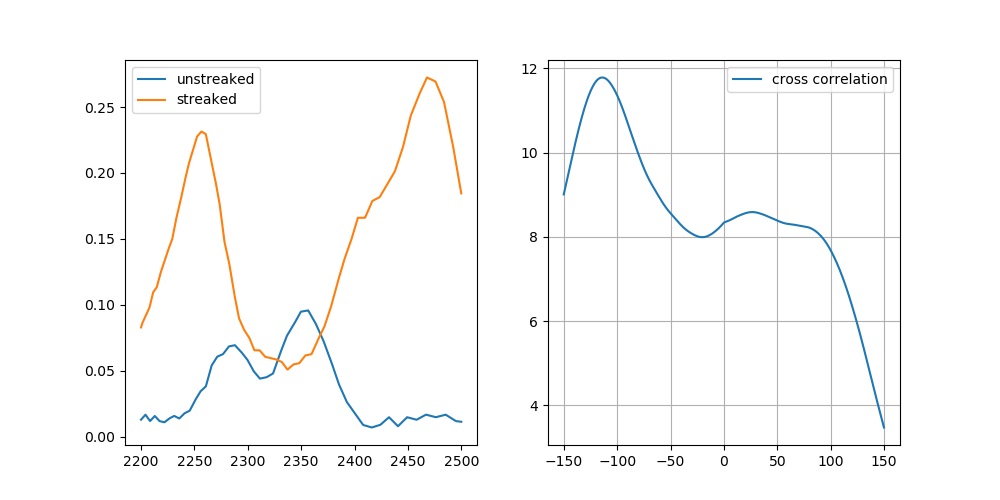

In [12]:
# Check one shot (be careful, could be a dark one!!) to see the TOF peak and cross correlation

shot = 2

print ('Delay for shot {} = {} with calibration = {} eV/fs'.format(shot, delays[shot]*ev2fsCalib, ev2fsCalib))
print (np.amax(input_data['0'],axis=1)[shot])
print (cross_corr[shot].sum())

plt.figure(figsize= (10,5))
plt.subplot(121)
plt.plot(palm.energy_range, input_data['0'][shot], label="unstreaked")
plt.plot(palm.energy_range, input_data['1'][shot], label="streaked")
plt.legend(loc="best")

plt.subplot(122)
plt.plot(lags, cross_corr[shot], label="cross correlation")
plt.legend(loc="best")
plt.grid()

# Analyse a series of files

In [13]:
datalist = glob(DIR + "*.BSREAD.h5")
datalist = sorted(datalist)
datalist

['/sf/alvra/data/p17589/raw/2020-07-02_YAG_timing_9/run_000284.BSREAD.h5',
 '/sf/alvra/data/p17589/raw/2020-07-02_YAG_timing_9/run_000285.BSREAD.h5',
 '/sf/alvra/data/p17589/raw/2020-07-02_YAG_timing_9/run_000286.BSREAD.h5',
 '/sf/alvra/data/p17589/raw/2020-07-02_YAG_timing_9/run_000287.BSREAD.h5',
 '/sf/alvra/data/p17589/raw/2020-07-02_YAG_timing_9/run_000288.BSREAD.h5',
 '/sf/alvra/data/p17589/raw/2020-07-02_YAG_timing_9/run_000289.BSREAD.h5',
 '/sf/alvra/data/p17589/raw/2020-07-02_YAG_timing_9/run_000290.BSREAD.h5',
 '/sf/alvra/data/p17589/raw/2020-07-02_YAG_timing_9/run_000291.BSREAD.h5',
 '/sf/alvra/data/p17589/raw/2020-07-02_YAG_timing_9/run_000292.BSREAD.h5',
 '/sf/alvra/data/p17589/raw/2020-07-02_YAG_timing_9/run_000293.BSREAD.h5',
 '/sf/alvra/data/p17589/raw/2020-07-02_YAG_timing_9/run_000294.BSREAD.h5',
 '/sf/alvra/data/p17589/raw/2020-07-02_YAG_timing_9/run_000295.BSREAD.h5',
 '/sf/alvra/data/p17589/raw/2020-07-02_YAG_timing_9/run_000296.BSREAD.h5',
 '/sf/alvra/data/p17589/r

## Next is to extract TT arrival times (choose FEL or laser as pump)

## This is for FEL pump

In [14]:
channel_list_pp = [channel_Events, channel_LaserDiode, channel_Laser_refDiode]
channel_list_all = channel_list_pp + [channel_Izero122, channel_delay_harm, channel_PALM_streak, channel_PALM_unstreak]

import itertools

datalist = glob(DIR + "*.BSREAD.h5")
datalist = sorted(datalist)

#ev2fsCalib= -20.723024835035712 #eV/fs    # This is from THz scan_508, p18182
#ev2fsCalib= -18.913301646032846 #eV/fs    # This is from THz scan_010, p18442
#ev2fsCalib = -3.5391553376634146 #eV/fs    # This is for 12 keV 
#ev2fsCalib = -12.172892970253786 #eV/fs     # This is for 7.1 keV
ev2fsCalib = -3.1824981756907595  #eV/fs    # This is for 7.5 keV

Delays_PALM_runs = []
Delays_mean = []
run_number = []

nshots = None

for fileName in datalist[0:5]:
    testdata = load_data.check_files_and_data(fileName)
    
    if (testdata):# and (i!=12):
        print ("Processing file {}". format(fileName))
        run_number.append(int(fileName.split('_')[-1].split('.')[0]))
        clear_output(wait=True)
        
        results_pp, results_FEL, FEL_reprate, ratio = load_data_compact_FEL_pump(channel_list_pp, channel_list_all, fileName)
        
        Laser_pump = results_pp[channel_LaserDiode].pump
        Laser_unpump = results_pp[channel_LaserDiode].unpump
        Laser_ref_pump = results_pp[channel_Laser_refDiode].pump
        Laser_ref_unpump = results_pp[channel_Laser_refDiode].unpump
        
        TOF = results_FEL[channel_PALM_streak]
        uTOF = results_FEL[channel_PALM_unstreak]
        Izero_FEL = results_FEL[channel_Izero122]
        
        prep_data = {"0":uTOF, "1":TOF}
        delays_PALM_eV, _, (input_data, lags, cross_corr, _) = palm.process(prep_data, debug=True)
        delays_PALM_fs = delays_PALM_eV * ev2fsCalib
        
        Laser_diff = -np.log10((Laser_pump/Laser_ref_pump) / (Laser_unpump/ Laser_ref_unpump)) / (Izero_FEL)
        
 #       Laser_diff = Laser_diff[:minlen]
 #       delays_PALM_fs = delays_PALM_fs[:minlen]
 #       Izero_FEL = Izero_FEL[:minlen]
        
        fullArraySize = len(delays_PALM_fs)
        beamOK = (Izero_FEL > 0)
        
        delays_beamOK = delays_PALM_fs[beamOK]
        NumberOK = len(delays_beamOK) 
        Delays_PALM_runs.append(delays_beamOK)
        
        print ('FEL @ {} Hz, ratio light/dark = {}:1, light shots are {}'.format(FEL_reprate, ratio, NumberOK))
        
        Delays_mean.append(np.nanmean(delays_beamOK))
    
        print ("Run {} ----- mean delay = {} fs".format(fileName.split('_')[-1].split('.')[0], \
                np.round(np.nanmean(delays_beamOK),3)))#, fileName,"pulseID =",pulse_id[0],)
            
Delays_PALM_all = np.asarray(list(itertools.chain.from_iterable(Delays_PALM_runs)))
Delays_PALM_runs = np.asarray(Delays_PALM_runs)
Delays_mean = np.asarray(Delays_mean)

print ("Job done!")
print ("Calibration factor used is {} eV/fs".format(ev2fsCalib))

Pump rep rate (FEL) is 50.0 Hz
Probe rep rate (laser) is 100.0 Hz

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet       10001 / 10001 ->  0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PALMK118:CH1_BUFFER    5000 / 10001 -> 50% loss ▇▇▇▇▇
SAROP11-PALMK118:CH2_BUFFER    5000 / 10001 -> 50% loss ▇▇▇▇▇
SAROP11-PBPS122:INTENSITY      5000 / 10001 -> 50% loss ▇▇▇▇▇
SLAAR11-LMOT-M453:ENC_1_BS    10001 / 10001 ->  0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH0:VAL_GET 10001 / 10001 ->  0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH2:VAL_GET 10001 / 10001 ->  0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 5000 / 10001 -> 50% loss

--------------------------------------------------------------------------------

FEL @ 50.0 Hz, ratio light/dark = 100.0:1, light shots are 5000
Run 000288 ----- mean delay = 207.725 fs
Job done!
Calibration factor used is -3.1824981756907595 eV/fs


In [15]:
print (Delays_PALM_all.shape, Delays_PALM_runs.shape, len(run_number))

(25000,) (5, 5000) 5


## This is for laser pump

In [ ]:
channel_list_pp = [channel_Events]
channel_list_all = channel_list_pp + [channel_Izero122, channel_PALM_streak, channel_PALM_unstreak]

import itertools

datalist = glob(DIR + "*.BSREAD.h5")
datalist = sorted(datalist)

#ev2fsCalib= -20.723024835035712 #eV/fs    # This is from THz scan_508, p18182
#ev2fsCalib= -18.913301646032846 #eV/fs    # This is from THz scan_010, p18442
#ev2fsCalib = -3.5391553376634146 #eV/fs    # This is for 12 keV 
#ev2fsCalib = -12.172892970253786 #eV/fs     # This is for 7.1 keV
ev2fsCalib = -3.1824981756907595  #eV/fs    # This is for 7.5 keV

Delays_PALM_runs = []
Delays_mean = []
run_number = []

nshots = None

for fileName in datalist[0:5]:
    testdata = load_data.check_files_and_data(fileName)
    
    if (testdata):# and (i!=12):
        print ("Processing file {}". format(fileName))
        run_number.append(int(fileName.split('_')[-1].split('.')[0]))
        clear_output(wait=True)
        
        results_pp, results_FEL, FEL_reprate, ratio = load_data_compact_FEL_pump(channel_list_pp, channel_list_all, fileName)
        
        Laser_pump = results_pp[channel_LaserDiode].pump
        Laser_unpump = results_pp[channel_LaserDiode].unpump
        Laser_ref_pump = results_pp[channel_Laser_refDiode].pump
        Laser_ref_unpump = results_pp[channel_Laser_refDiode].unpump
        
        TOF = results_FEL[channel_PALM_streak]
        uTOF = results_FEL[channel_PALM_unstreak]
        Izero_FEL = results_FEL[channel_Izero122]
        
        prep_data = {"0":uTOF, "1":TOF}
        delays_PALM_eV, _, (input_data, lags, cross_corr, _) = palm.process(prep_data, debug=True)
        delays_PALM_fs = delays_PALM_eV * ev2fsCalib
        
        Laser_diff = -np.log10((Laser_pump/Laser_ref_pump) / (Laser_unpump/ Laser_ref_unpump)) / (Izero_FEL)
        
 #       Laser_diff = Laser_diff[:minlen]
 #       delays_PALM_fs = delays_PALM_fs[:minlen]
 #       Izero_FEL = Izero_FEL[:minlen]
        
        fullArraySize = len(delays_PALM_fs)
        beamOK = (Izero_FEL > 0)
        
        delays_beamOK = delays_PALM_fs[beamOK]
        NumberOK = len(delays_beamOK) 
        Delays_PALM_runs.append(delays_beamOK)
        
        print ('FEL @ {} Hz, ratio light/dark = {}:1, light shots are {}'.format(FEL_reprate, ratio, NumberOK))
        
        Delays_mean.append(np.nanmean(delays_beamOK))
    
        print ("Run {} ----- mean delay = {} fs".format(fileName.split('_')[-1].split('.')[0], \
                np.round(np.nanmean(delays_beamOK),3)))#, fileName,"pulseID =",pulse_id[0],)
            
Delays_PALM_all = np.asarray(list(itertools.chain.from_iterable(Delays_PALM_runs)))
Delays_PALM_runs = np.asarray(Delays_PALM_runs)
Delays_mean = np.asarray(Delays_mean)

print ("Job done!")
print ("Calibration factor used is {} eV/fs".format(ev2fsCalib))

<IPython.core.display.Javascript object>


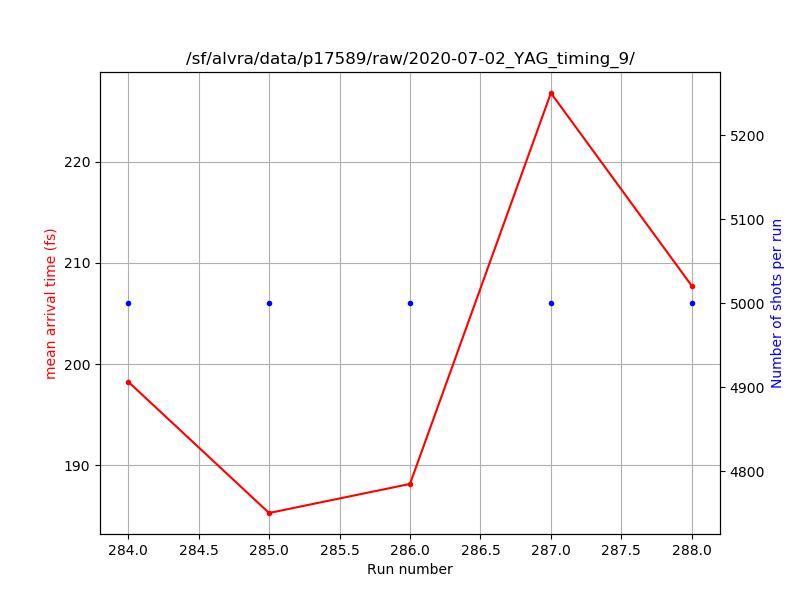

In [19]:
fig, ax1 = plt.subplots(figsize=(8,6))
plt.title(DIR)

plt.grid()
plt.xlabel('Run number')
ax1.plot(run_number, Delays_mean, label = 'Arrival time', marker ='.', color = 'r')
ax1.set_ylabel('mean arrival time (fs)', color='r')

ax2 = ax1.twinx()
for i in range(len(Delays_PALM_runs)):
    xe = run_number[i]
    ye = len(Delays_PALM_runs[i])
    ax2.plot(xe, ye, label = 'mean arrival time',marker = '.', color ='b')
ax2.set_ylabel('Number of shots per run', color='b')

plt.show()

<IPython.core.display.Javascript object>


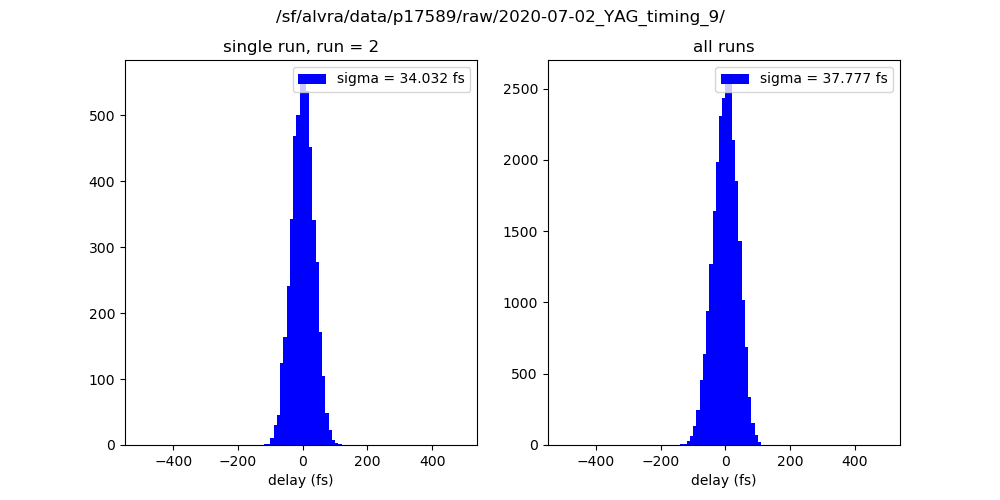

5000


In [20]:
run = 2

plt.figure(figsize=(10,5))
plt.suptitle(DIR)

plt.subplot(121)
plt.hist((Delays_PALM_runs[run]-np.nanmean(Delays_PALM_runs[run])), bins =np.arange(-500,500,10), facecolor='blue', \
         label="sigma = {} fs".format(np.round(np.nanstd(Delays_PALM_runs[run]-np.nanmean(Delays_PALM_runs[run])), 3), alpha=0.5))
plt.title('single run, run = {}'.format(run))
plt.legend(loc="best")
plt.xlabel ('delay (fs)')
plt.show()

plt.subplot(122)
#plt.hist (Delays_PALM_all, bins =np.arange(-500,500,10), facecolor='blue')
plt.hist((Delays_PALM_all-np.nanmean(Delays_PALM_all)), bins =np.arange(-500,500,10), facecolor='blue', \
         label="sigma = {} fs".format(np.round(np.nanstd(Delays_PALM_all.ravel()-np.nanmean(Delays_PALM_all)), 3), alpha=0.5))
plt.title('all runs')
plt.legend(loc="best")
plt.xlabel ('delay (fs)')
plt.show()

print (len(Delays_PALM_runs[run]))

In [ ]:
saveDir = "/das/work/p17/p17569/alvra_beamline_scripts/ProcessedData/"    # dest folder (needs to exist)
fn = str(saveDir + "Runs_451_513.h5")

hf = h5py.File(fn, 'w')
hf.create_dataset('Total_light_1D', data=Total_light_1D)
hf.create_dataset('Total_pulseIDS', data=Total_pulseIDS)
hf.create_dataset('Total_strData', data=Total_strData)
hf.create_dataset('Total_refData', data=Total_refData)
hf.create_dataset('Total_corrData', data=Total_corrData)
hf.close()

In [ ]:
itemindex = np.where(Total_light_1D==66.05130091)

In [ ]:
import pandas as pd
#input_data_max = np.amax(input_data['0'],axis=1)
df = pd.DataFrame(Total_light_1D)
Avg = df.rolling(300).mean()

In [ ]:
plt.figure(figsize= (10,5))
#plt.plot(Total_light_1D[0::1000])
plt.plot(Total_pulseIDS, Total_light_1D[:],'.')
#plt.plot(Total_light_1D[:],'.')

plt.plot(Total_pulseIDS, Avg,'.', ms=1 )


for xc in pulseID_first:
    if run_number[pulseID_first.index(xc)]%5 ==0:
        plt.axvline(x=xc, color = 'r')
        #plt.text(xc,200, pulseID_first.index(xc)+start_index,color = 'r')
        plt.text(xc,350, run_number[pulseID_first.index(xc)],color = 'r')

plt.ylabel("Arrival time (fs)")
#plt.xlabel("shot number")
plt.xlabel("Pulse ID")

plt.ticklabel_format(useOffset=False, style='plain')
plt.ylim((-480,400))
plt.grid()
